In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from skimage.transform import resize

In [4]:
# data from https://www.kaggle.com/shravankumar9892/image-colorization
# download data an put it in a folder in the root called "data"

imgs_gray = np.load("./data/l/gray_scale.npy").reshape((25000, 224, 224, 1))
ab3 = np.load("./data/ab/ab/ab3.npy")
ab2 = np.load("./data/ab/ab/ab2.npy")
ab1 = np.load("./data/ab/ab/ab1.npy")

In [5]:
imgs_ab = np.concatenate((ab1, ab2, ab3), axis=0)

# print(imgs_gray.shape)
# print(imgs_ab.shape)

In [6]:
# splits the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(imgs_gray, imgs_ab, test_size=0.2, random_state=42, shuffle=True)
X_train.astype('float')
X_test.astype('float')
y_train.astype('float')
y_test.astype('float')
print("X_train " + str(X_train.shape))
print("X_test " + str(X_test.shape))
print("y_train " + str(y_train.shape))
print("y_train " + str(y_train.shape))


X_train (20000, 224, 224, 1)
X_test (5000, 224, 224, 1)
y_train (20000, 224, 224, 2)
y_train (20000, 224, 224, 2)


In [7]:
# loads the inceptionResNetV2 for prediction of large features of the images

inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights("./data/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5")
inception.graph = tf.compat.v1.get_default_graph()

(300, 300, 3)


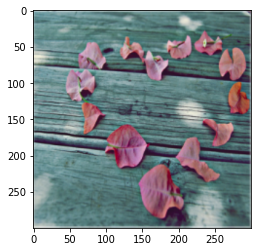

In [8]:
def l_ab_to_RGB(l, ab):
    shape = (l.shape[0],l.shape[1],3)
    img = np.zeros(shape)
    img[:,:,0] = l[:,:,0]
    img[:,:,1:]= ab
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img
def display(img):
    plt.figure()
    plt.set_cmap('gray')
    plt.imshow(img)
    plt.show()
    
img = l_ab_to_RGB(imgs_gray[1], imgs_ab[1])
# img = np.resize(img, (256, 256, 3))
img = np.array(resize(img, (300, 300, 3), mode='constant'))
print(img.shape)

display(img)